## DeepAR (based off of AWS synthetic data example) version 0.1

This version if going to follow from this <a href = "https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.ipynb">AWS DeepAR synthetic</a> data example.

In [36]:
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import sagemaker
import boto3

In [134]:
bucket = '######'
prefix = 'sagemaker/synthetic-example'

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

freq = '5min'
prediction_length = 30
context_length = 50

In [73]:
data_key = 'Bainbridge_Departures_Master.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(data_location, parse_dates = ["timestamps"], index_col = "timestamps")
df = df.asfreq(freq)

In [37]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

In [5]:
df_first_year = 2013
df_last_year = 2017

`time_series` is a list of `pandas.Series` objects, each series is a month worth of `seconds_late` data

In [107]:
time_series = []

for year in range (df_first_year, df_last_year + 1):
    for month in range(1,13):
        index = "{}-{}".format(year, month)
        time_series.append((df[index]["seconds_late"]))

In [108]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

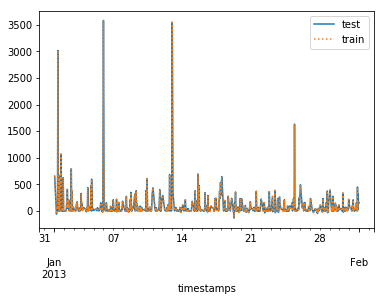

In [18]:
time_series[0].plot(label='test')
time_series_training[0].plot(label='train', ls=':')
plt.legend()
plt.show()

The following utility functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3.

In [22]:
import json
import s3fs

In [19]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [33]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

### Train a model

In [38]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='deepar-bainbridge-departures-ae',
    output_path="s3://" + s3_output_path
)

In [41]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [42]:
estimator.set_hyperparameters(**hyperparameters)

In [43]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: deepar-bainbridge-departures-ae-2019-04-10-20-44-40-988


2019-04-10 20:44:41 Starting - Starting the training job...
2019-04-10 20:44:42 Starting - Launching requested ML instances.........
2019-04-10 20:46:18 Starting - Preparing the instances for training.........
2019-04-10 20:48:06 Downloading - Downloading input data
2019-04-10 20:48:06 Training - Training image download completed. Training in progress..
Arguments: train
[04/10/2019 20:48:10 INFO 140704526260032] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}


[04/10/2019 20:48:30 INFO 140704526260032] Epoch[9] Batch[5] avg_epoch_loss=8.519809
[04/10/2019 20:48:30 INFO 140704526260032] Epoch[9] Batch [5]#011Speed: 300.29 samples/sec#011loss=8.519809
[04/10/2019 20:48:31 INFO 140704526260032] Epoch[9] Batch[10] avg_epoch_loss=7.420812
[04/10/2019 20:48:31 INFO 140704526260032] Epoch[9] Batch [10]#011Speed: 276.35 samples/sec#011loss=6.102016
[04/10/2019 20:48:31 INFO 140704526260032] processed a total of 321 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1602.3411750793457, "sum": 1602.3411750793457, "min": 1602.3411750793457}}, "EndTime": 1554929311.059202, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1554929309.456807}

[04/10/2019 20:48:31 INFO 140704526260032] #throughput_metric: host=algo-1, train throughput=200.318246113 records/second
[04/10/2019 20:48:31 INFO 140704526260032] #progress_metric: host=algo-1, completed 50 % of epochs
[04/10/2019 20:48:31 INFO 140704

#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 5616.101980209351, "sum": 5616.101980209351, "min": 5616.101980209351}}, "EndTime": 1554929333.715859, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1554929328.099851}

[04/10/2019 20:48:53 INFO 140704526260032] #test_score (algo-1, RMSE): 405.862045528
[04/10/2019 20:48:53 INFO 140704526260032] #test_score (algo-1, mean_wQuantileLoss): 0.714605
[04/10/2019 20:48:53 INFO 140704526260032] #test_score (algo-1, wQuantileLoss[0.1]): 0.488056
[04/10/2019 20:48:53 INFO 140704526260032] #test_score (algo-1, wQuantileLoss[0.2]): 0.651659
[04/10/2019 20:48:53 INFO 140704526260032] #test_score (algo-1, wQuantileLoss[0.3]): 0.753556
[04/10/2019 20:48:53 INFO 140704526260032] #test_score (algo-1, wQuantileLoss[0.4]): 0.813438
[04/10/2019 20:48:53 INFO 140704526260032] #test_score (algo-1, wQuantileLoss[0.5]): 0.835052
[04/10/2019 20:48:53 INFO 140704526260032] #test_score (algo-1, wQu

### Create endpoint and predictor

In [44]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    #instance_type='ml.m4.xlarge',
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: deepar-bainbridge-departures-ae-2019-04-10-20-44-40-988
INFO:sagemaker:Creating endpoint-config with name deepar-bainbridge-departures-ae-2019-04-10-20-44-40-988
INFO:sagemaker:Creating endpoint with name deepar-bainbridge-departures-ae-2019-04-10-20-44-40-988


---------------------------------------------------------------------------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [45]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [136]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

### Make predictions and plot results

Now we can use the previously created `predictor` object. For simplicity, we will predict only the first few time series used for training, and compare the results with the actual data we kept in the test set.

In [137]:
list_of_df = predictor.predict(time_series_training[:1])
actual_data = time_series[:1]

In [138]:
def plot_results(list_of_df):
    for k in range(len(list_of_df)):
        plt.figure(figsize=(12,6))
        actual_data[k][-prediction_length-context_length:].plot(label='target')
        p10 = list_of_df[k]['0.1']
        p90 = list_of_df[k]['0.9']
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        list_of_df[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

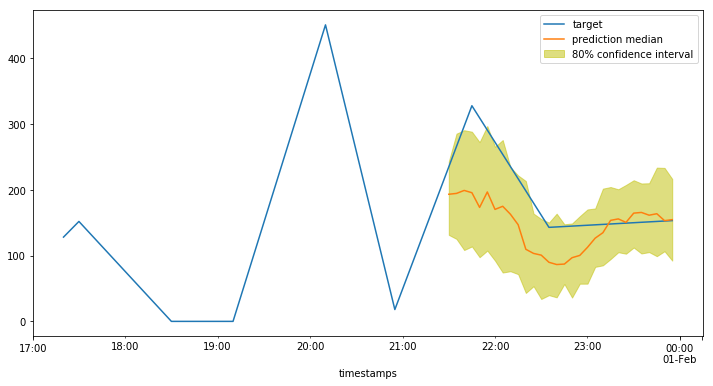

In [139]:
plot_results(list_of_df)

## Making predictions with daily series

In the first prediction above the predictor takes in a month worth of data. I want to see if I can also just pass in one day's worth of data to the same model.

In [141]:
time_series = []

for year in range (df_first_year, df_last_year + 1):
    for month in range(1,13):
        for day in range(1, calendar.monthrange(year, month)[1] + 1):
            index = "{}-{}-{}".format(year, month, day)
            time_series.append((df[index]["seconds_late"]))
            
time_series_training = []

for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

In [142]:
list_of_df = predictor.predict(time_series_training[:1])
actual_data = time_series[:1]

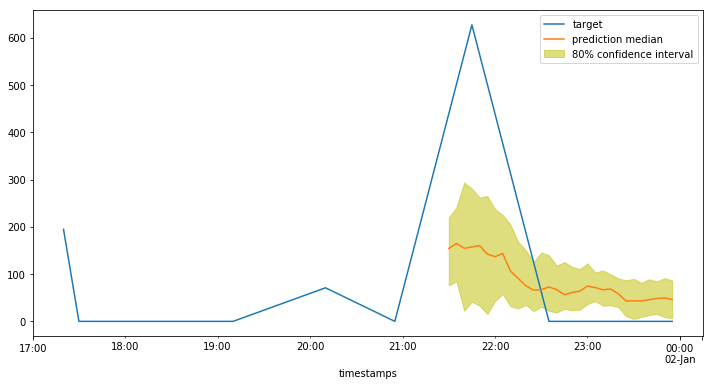

In [143]:
plot_results(list_of_df)